# Polynomial Regression with Flux/Zygote

Chapter 1 of any machine learning book always has a short paragraph on linear regression.

Toolkits of the like of TensorFlow or Flux are useful in their ability to perform complex derivatives and orchestrate training algorithms on complex nonlinear and deep models. However, the focus nowadays is on optimizing the hottest neural network with minibatched stochastic gradient descent, which is usually only one chapter of an ML textbook. There are plently more classes of models that this programming approach can help us perform and develop. It's important that any automatic ML/Deep Learning package be able to derive these simple models. We can take the hard work out of deriving and implementing newer non-neural network models too.

A linear model is fit by:
\begin{equation}
f(x) = W basis(x) + b
\end{equation}
where "basis" is the The set $basis(x)=\{x\}$ is a linear model. We'll be doing polynomials where $basis(p)(x)=\{x,x^2,...x^p\}$. The solution is the well known linear least squares problem,
\begin{equation}
P = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T y
\end{equation}
where $X$ is a rectangular matrix depending on the basis set and data, $X_{ij} = basis_i(x_j)$.

We're going to take a different approach: instead of starting with the least-squares equation and deriving the matrix equation, we're going to define **the code for a function** and perform source code transformations on to get the **program** we need that performs the regression.

To get this to work, we have to use a bleeding edge branch of Zygote:
```juia
] add Zygote#mutate
```

In [1]:
include("./AfqsJuliaUtil.jl")
using .AfqsJuliaUtil

First, let's make a simple dataset with known expected values:

In [2]:
dat_x = collect(1:0.1:10);
dat_y = 0.1*dat_x.^2 .+ 5 .+ 0.5*rand(length(dat_x));
dat_x = reshape(dat_x,(1,:));
dat_y = reshape(dat_y,(1,:));

We use the arguments format for parameters, in which they get passed through the function, rather than the implicit parameters format. A model has three arguments: hyperparameters, parameters, and input features:
\begin{equation}
f_{hyper}(x;params)
\end{equation}
Conceptually, I prefer this way of thinking about it, but juggling the arguments is complicated for the model developer. 

In [26]:
poly = AfqsJuliaUtil.@polynomial_function(1,3)
P0 = rand(4)
f(x,P) = P[1:3]'*poly(x).+P[4];

With this "simple" expression, we will use Flux and Zygote to optimize the values of the parameters:

In [27]:
using Flux, Zygote, Plots
loss(x,y, P) = Flux.mse(y,f(x,P))

loss (generic function with 1 method)

We check that it works:

In [28]:
loss(dat_x,dat_y, P0)

95585.53564978765

\begin{equation}
P = \arg \min_P \left\| y-f(x;P)\right\|
\end{equation}

\begin{equation}
\frac{\partial L}{\partial P} = 0
\end{equation}

\begin{equation}
\left[\frac{\partial^2 L}{\partial P^2}\right]\Delta P = -\frac{\partial L}{\partial P}
\end{equation}

So... let's just type that!

In [29]:
gradx_fwd(x) = Zygote.forward_jacobian( (P->loss(dat_x,dat_y, P)), x )[2];
hessx_fwd(x) = Zygote.forward_jacobian( gradx_fwd, x );

In [30]:
#gradx(x) = Zygote.gradient( (P->loss(dat_x,dat_y, P)), x )[1]

To get the matrix, we just just evaluate it:

In [31]:
R,K=hessx_fwd(P0)

([3474.67; 29007.5; 2.49258e5; 433.691], [74.3 560.45 4506.19 11.0; 560.45 4506.19 37738.1 74.3; 4506.19 37738.1 3.25071e5 560.45; 11.0 74.3 560.45 2.0])

Note how the gradient (R) is the same as the backward differentiated case.

To do the least squares, we just solve the resulting system of equations:

In [32]:
ΔP = K\R;
P = P0 - ΔP

4×1 Array{Float64,2}:
 -0.01296390262039171   
  0.10627247582199706   
 -0.00047216665684812753
  5.209583347214992     

Notice how we recover `P[2]==0.1` and `P[4]==5`. We can verify that it looks right:

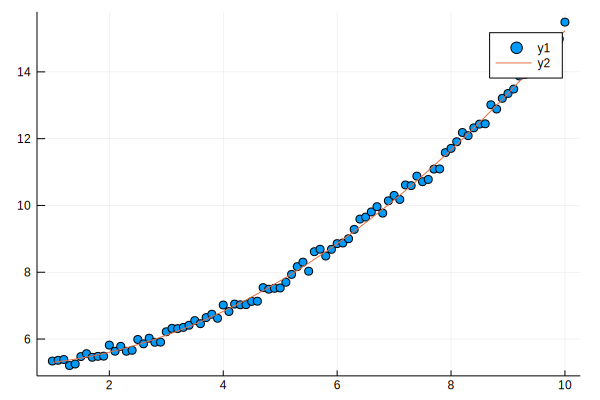

In [33]:
scatter(dat_x',dat_y')
plot!(dat_x',f(dat_x,P)')

## Why do we want to do this?


In [14]:
using StaticArrays

In [15]:
const ps = SVector(P0...)

4-element SArray{Tuple{4},Float64,1,4}:
 0.6253444358890872 
 0.5068956962124429 
 0.15361067090099456
 0.37969059161710894

In [16]:
@eval f_frz(x::AbstractArray) = f(x,$ps)

f_frz (generic function with 1 method)

In [17]:
@code_llvm f_frz([1.0])


;  @ In[16]:1 within `f_frz'
define nonnull %jl_value_t addrspace(10)* @japi1_f_frz_14186(%jl_value_t addrspace(10)*, %jl_value_t addrspace(10)**, i32) #0 {
top:
  %3 = alloca %jl_value_t addrspace(10)*, i32 4
  %gcframe = alloca %jl_value_t addrspace(10)*, i32 4
  %4 = bitcast %jl_value_t addrspace(10)** %gcframe to i8*
  call void @llvm.memset.p0i8.i32(i8* %4, i8 0, i32 32, i32 0, i1 false)
  %5 = alloca %jl_value_t addrspace(10)**, align 8
  store volatile %jl_value_t addrspace(10)** %1, %jl_value_t addrspace(10)*** %5, align 8
  %6 = call %jl_value_t*** inttoptr (i64 4467308192 to %jl_value_t*** ()*)() #3
  %7 = getelementptr %jl_value_t addrspace(10)*, %jl_value_t addrspace(10)** %gcframe, i32 0
  %8 = bitcast %jl_value_t addrspace(10)** %7 to i64*
  store i64 4, i64* %8
  %9 = getelementptr %jl_value_t**, %jl_value_t*** %6, i32 0
  %10 = load %jl_value_t**, %jl_value_t*** %9
  %11 = getelementptr %jl_value_t addrspace(10)*, %jl_value_t addrspace(10)** %gcframe, i32 1
  %12 = bit

In [18]:
pf=reshape(P,(:,))

4-element Array{Float64,1}:
 0.7549516562267077  
 0.10014133684744914 
 0.011626471851131387
 5.2438205089705106  

In [19]:
@inline g(x::Real,P::StaticArray) = P[1:3].*poly(x).+P[4];

In [20]:
@code_lowered g(1.0,:($ps))

CodeInfo(
1 ─      nothing
│   %2 = 1:3
│   %3 = (Base.getindex)(P, %2)
│   %4 = (Main.poly)(x)
│   %5 = (Base.broadcasted)(Main.:*, %3, %4)
│   %6 = (Base.getindex)(P, 4)
│   %7 = (Base.broadcasted)(Main.:+, %5, %6)
│   %8 = (Base.materialize)(%7)
└──      return %8
)

In [21]:
 g(1.0,ps)

3-element Array{Float64,1}:
 1.005035027506196 
 0.8865862878295518
 0.5333012625181035

## Which way do we want to go?

Ideally, we would want to backward differentiate the loss because it's more efficient when $N_{outputs} \ll N_{inputs}$. I'm note sure which algorithm would be better for the derivative of the gradient; probably forward differentiation. However, Zygote still has trouble forward differentiating something that was backward differentiated:

In [22]:
Zygote.hessian( (P->loss(dat_x,dat_y, P)), P0 )

MethodError: MethodError: no method matching (::Zygote.Jnew{ForwardDiff.Dual{Nothing,Float64,4},Nothing,false})(::ForwardDiff.Dual{Nothing,Float64,4})
Closest candidates are:
  Jnew(!Matched::Union{Nothing, RefValue, NamedTuple}) where {T, G} at /Users/afq/.julia/packages/Zygote/p7pxY/src/lib/lib.jl:218